# Chat

Recall the overall workflow for retrieval augmented generation (RAG):

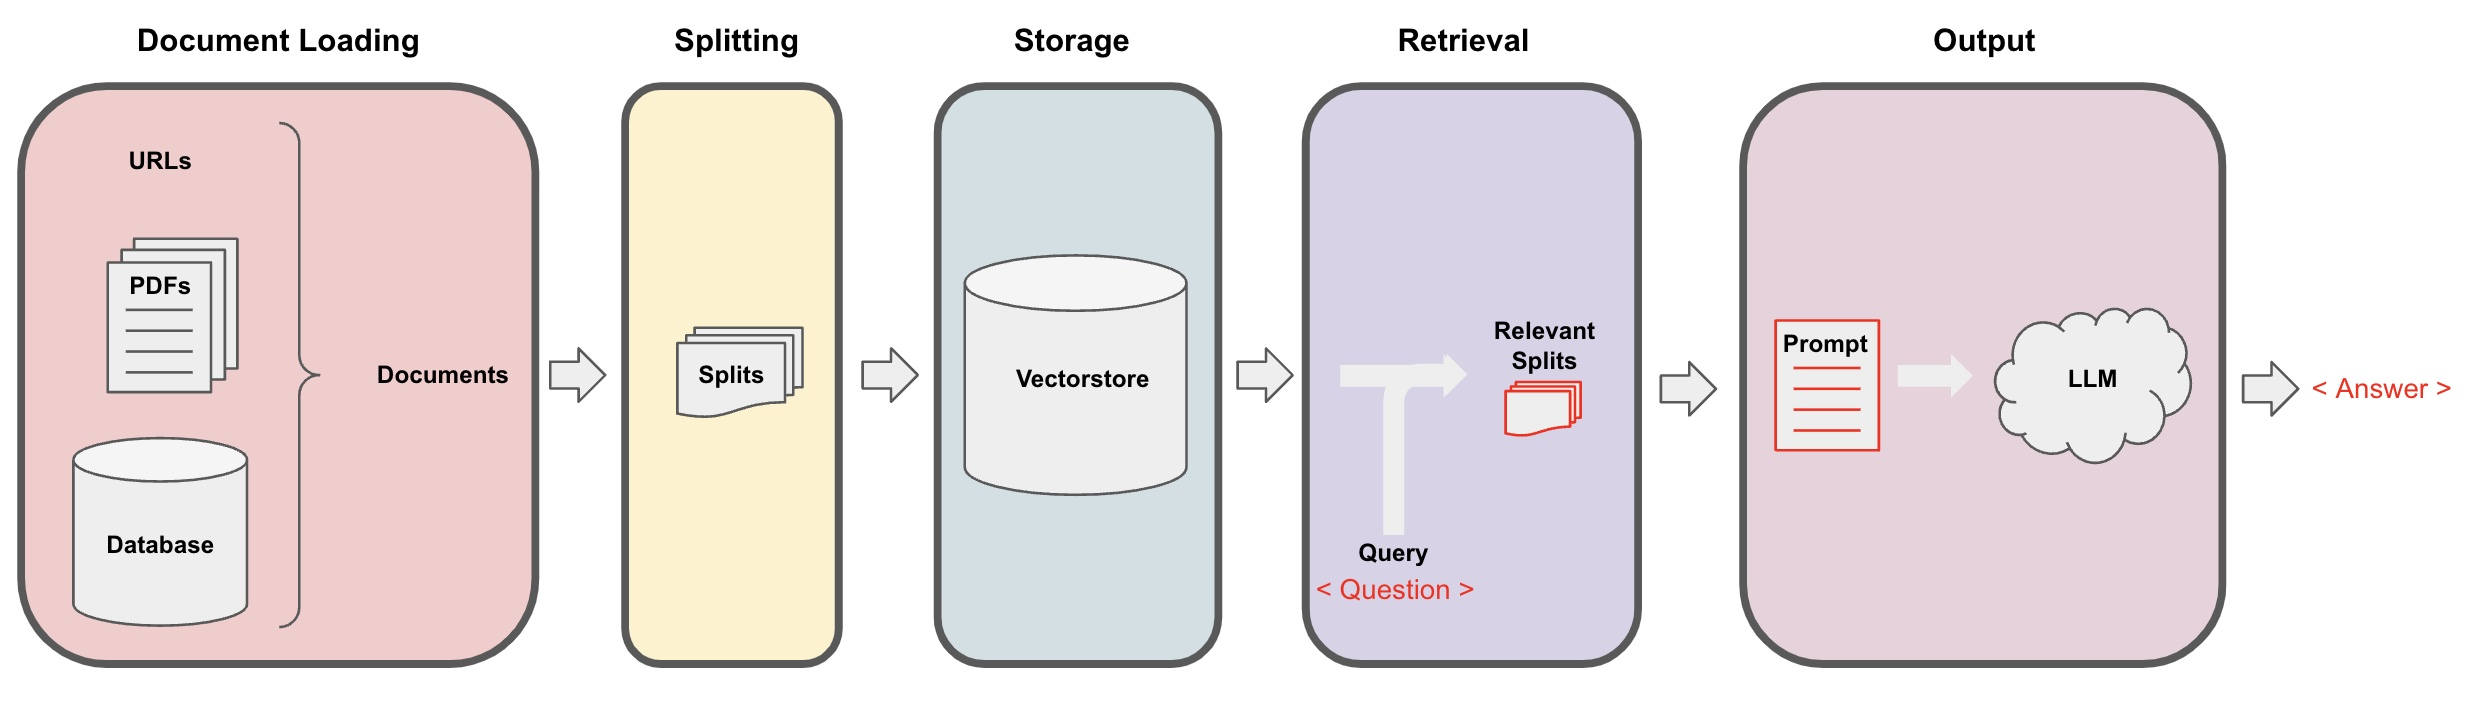

We discussed `Document Loading` and `Splitting` as well as `Storage` and `Retrieval`.

We then showed how `Retrieval` can be used for output generation in Q+A using `RetrievalQA` chain.

 If you wish to experiment on the `LangSmith platform` (previously known as LangChain Plus):

 * Go to [LangSmith](https://www.langchain.com/langsmith) and sign up
 * Create an api key from your account's settings
 * Create an Project

In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
persist_directory = 'data/docs/chroma/'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [2]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

3

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
llm.invoke("Hello world!")

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 10, 'total_tokens': 19}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-93c2cf0f-4804-4165-84f6-9d46d079ed95-0', usage_metadata={'input_tokens': 10, 'output_tokens': 9, 'total_tokens': 19})

In [6]:
# Build prompt
from langchain_core.prompts import PromptTemplate
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

# Run chain
from langchain.chains import RetrievalQA
question = "Is probability a class topic?"
qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectordb.as_retriever(),
                                       return_source_documents=True,
                                       chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})


result = qa_chain.invoke({"query": question})
result["result"]

'Yes, probability is a class topic assumed to be familiar to students, along with basic statistics and linear algebra. Thanks for asking!'

### Memory

In [7]:
from langchain.memory import ConversationBufferMemory 
# ConversationBufferMemory is a memory that stores the list of chat messagess in history 
# and it is oging to pass those messages along with the question to the chatbot everytime
memory = ConversationBufferMemory(
    memory_key="chat_history", # line it up with the input variable in the prompt
    return_messages=True # return the chat history as a list of messages as opposed to a single string
)

### ConversationalRetrievalChain

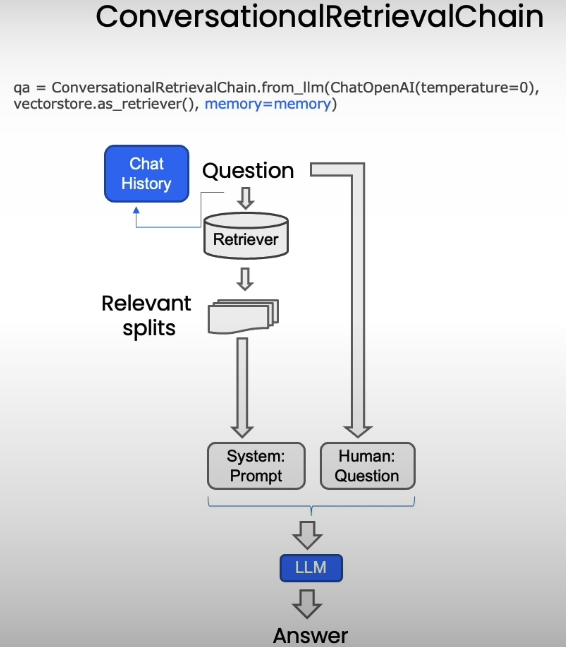

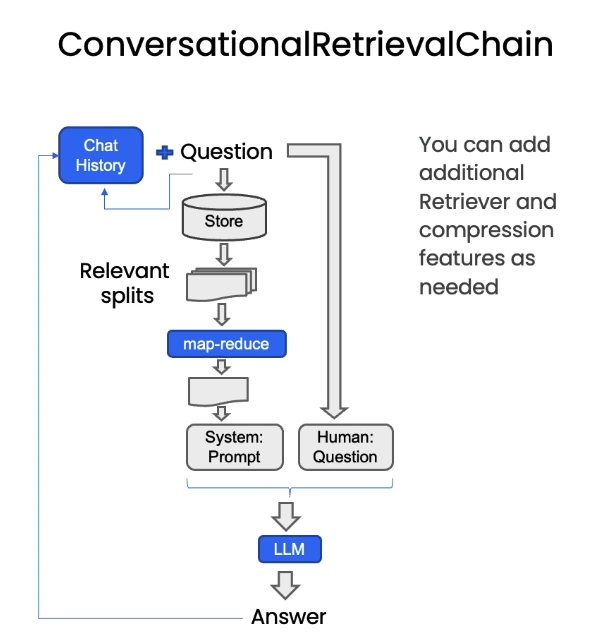

In [8]:
from langchain.chains import ConversationalRetrievalChain 
# add a step that take the history and new question and 
# condense it into a stand-alone question to pass to the vector store to loop up relevant documents
retriever=vectordb.as_retriever()
qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=retriever,
    memory=memory
)

In [9]:
question = "Is probability a class topic?"
result = qa.invoke({"question": question})

In [10]:
result['answer']

'Yes, probability is a class topic. The instructor assumes familiarity with basic probability and statistics for the course.'

In [12]:
question = "why are those prerequesites needed?"
result = qa.invoke({"question": question})

In [13]:
result['answer']

'Familiarity with basic probability and statistics is needed for the course because the material covered in the class involves concepts such as random variables, expectation, variance, and other statistical measures. Understanding these concepts is crucial for grasping the machine learning algorithms and techniques that will be taught.'

# Create a chatbot that works on your documents

In [1]:
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_community.document_loaders import TextLoader
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import PyPDFLoader

The chatbot code has been updated a bit since filming. The GUI appearance also varies depending on the platform it is running on.

In [2]:
def load_db(file, chain_type, k):
    # load documents
    loader = PyPDFLoader(file)
    documents = loader.load()
    # split documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    docs = text_splitter.split_documents(documents)
    # define embedding
    embeddings = OpenAIEmbeddings()
    # create vector database from data
    db = DocArrayInMemorySearch.from_documents(docs, embeddings)
    # define retriever
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
    # create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0), 
        chain_type=chain_type, 
        retriever=retriever, 
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa 
